# [PRD] Prediction of the output power (phase 2)

This notebook guides the reader through the solution proposed on the data challenge. The goal is to predict the output wind power of a wind turbine farm given historical data and weather forecasts.

The first cell reads the input data and pre-processes it (timestamps, derived fields).

In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

# training files
raw_files_dir = os.path.join('..', 'data', 'historical_processed', 'raw')
forecast_files_dir = os.path.join('..', 'data', 'historical_processed', 'forecasts')

def read_files (raw_files_dir, forecast_files_dir):

    df_list = []
    for f in os.listdir(raw_files_dir):
        df_list.append(pd.read_csv(os.path.join(raw_files_dir, f)))
    df_raw = pd.concat(df_list)
    df_raw['timestamp'] = pd.to_datetime(df_raw.unixtime, unit='s')
    df_raw.drop('unixtime', axis=1, inplace=True)
    # create field minutes and timestamp only driven by hour
    df_raw['day'] = df_raw.timestamp.apply(lambda x: pd.Timestamp(x.date()))
    df_raw['fcast_day'] = df_raw.day + pd.Timedelta(1, 'd')

    df_list = []
    for f in os.listdir(forecast_files_dir):
        df_list.append(pd.read_csv(os.path.join(forecast_files_dir, f)))
    df_fcast = pd.concat(df_list)
    df_fcast.rename(columns={'WNACWindSpeed':'WNACWindSpeed_fcast', 'WNACAmbTemp':'WNACAmbTemp_fcast'}, inplace=True)
    # timestamp for prediction is in the future
    df_fcast['fcast_day'] = pd.to_datetime(df_fcast.unixtime, unit='s')
    df_fcast.drop('unixtime', axis=1, inplace=True)
    df_fcast['fcast_time'] = df_fcast.fcast_day + df_fcast.range.apply(lambda x: pd.Timedelta(x, 's'))
    
    return df_raw, df_fcast

df_raw, df_fcast = read_files(raw_files_dir, forecast_files_dir)

## 1) Analysis of forecasted variables  (wind, temperature)
This analysis shows how well the prediction variables $ \hat{x_{wind}}(\tau, d) $ and $ \hat{x_{temp}}(\tau, d) $ compare to their real values

$$ \Delta x_{wind} (\tau, d) = | \hat{x_{wind}}(\tau, d) - x_{wind}(d+\tau) | $$
$$ \Delta x_{temp} (\tau, d) = | \hat{x_{temp}}(\tau, d) - x_{temp}(d+\tau) | $$

Being

* $\tau$ the prediction range
* $d$ the day of the prediction

The correlation analysis on Phase 1 showed that the variable to predict (WTURPower) is highly correlated and dependable on the wind speed and temperature. Hence, one cannot expect to improve the prediction accuracy of the power given a certain prediction quality of the inputs.


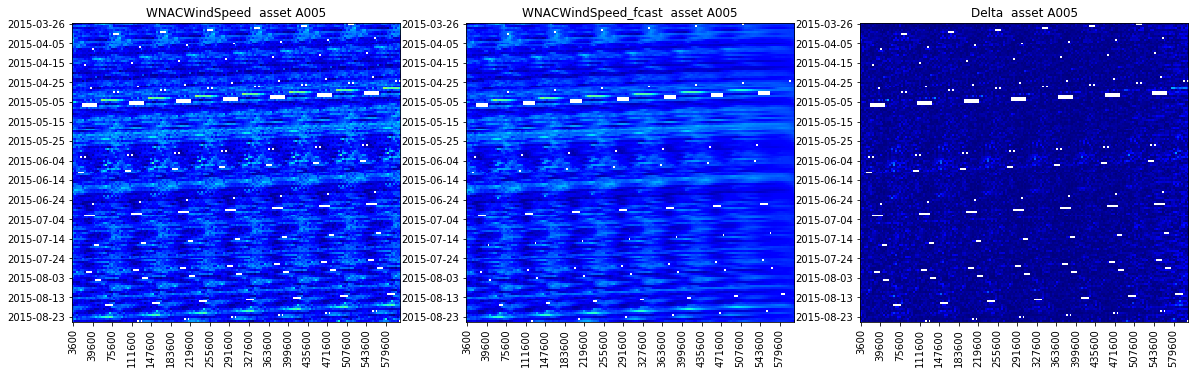

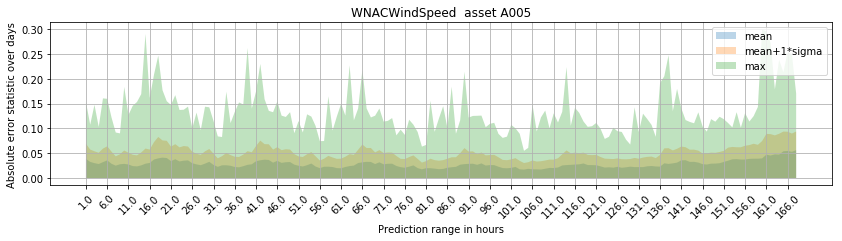

MSE error = 0.0014627676256664844
R2 score = 0.6875463423249475


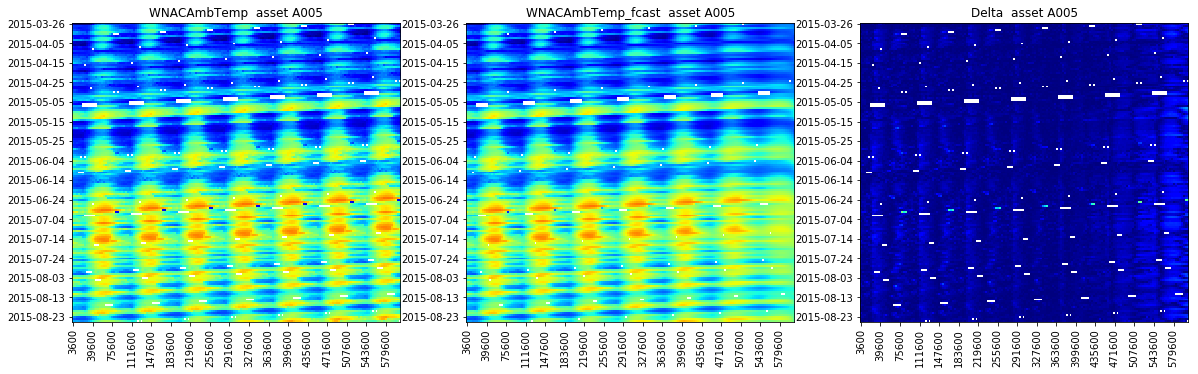

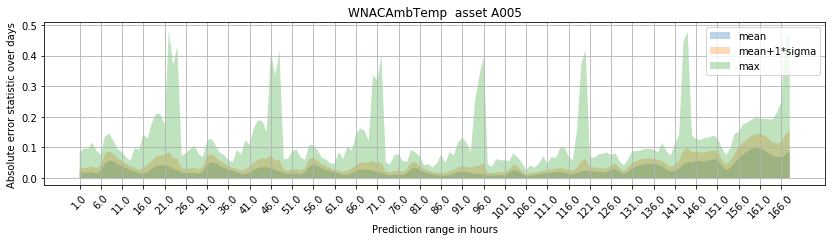

MSE error = 0.0018523776922195995
R2 score = 0.9344818841087101


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_prediction_field(df_pivot, f=10, subplot=None, title=''):
    if subplot is None:
        plt.figure(figsize=(8,8))
    else:
        plt.subplot(subplot)
    plt.imshow(df_pivot.values, cmap='jet', vmin=0, vmax=1)
    df_pivot.index = [x.date() for x in df_pivot.index]
    plt.xticks(range(0,df_pivot.shape[1], f), df_pivot.columns[::f], rotation='vertical')
    plt.yticks(range(0,df_pivot.shape[0], f), df_pivot.index[::f])
    plt.title(title)
    
def plot_prediction_stats(df_stats, f=5, subplot=None, title=''):
    if subplot is None:
        plt.figure(figsize=(14,3))
    plt.fill_between(df_stats.columns.values, 0, df_stats.loc['mean'], alpha=0.3)
    plt.fill_between(df_stats.columns.values, 0, df_stats.loc['mean']+df_stats.loc['std'], alpha=0.3)
    plt.fill_between(df_stats.columns.values, 0, df_stats.loc['max'], alpha=0.3)
    plt.xticks(df_stats.columns[::f], df_stats.columns[::f]/3600, rotation=45)
    plt.title(title)
    plt.xlabel('Prediction range in hours')
    plt.ylabel('Absolute error statistic over days')
    plt.legend(['mean', 'mean+1*sigma', 'max'])
    plt.grid()
    
def plot_prediction_report(df, true_var, pred_var, comment=''):
    plt.figure(figsize=(20,8))
    df_true = pd.pivot_table(df, index='fcast_day', columns='range', values=true_var)
    df_pred = pd.pivot_table(df, index='fcast_day', columns='range', values=pred_var)
    df_delta = abs(df_true-df_pred)
    plot_prediction_field(df_true, subplot=131, title=true_var+' '+comment)
    plot_prediction_field(df_pred, subplot=132, title=pred_var+' '+comment)
    plot_prediction_field(df_delta, subplot=133, title='Delta ' + comment)
    plot_prediction_stats(df_delta.describe(), title=true_var+' '+comment)
    plt.show() 
    print_performance(df.dropna()[true_var], df.dropna()[pred_var])
    
def print_performance(y, y_pred):
    print("MSE error = {}".format(mean_squared_error(y, y_pred)))
    print("R2 score = {}".format(r2_score(y, y_pred)))
    
def asset_performance_report(df, assets, true_var, pred_var, comment=''):
    for a in assets:
        df_a = df.loc[df.asset==a]
        plot_prediction_report(df_a, true_var, pred_var, comment=comment+' asset '+a)
        
var_fcast = ['WNACWindSpeed', 'WNACAmbTemp']
a = 'A005'
df_raw_a = df_raw.loc[df_raw.asset==a].set_index('timestamp')
df_fcast_a = df_fcast.loc[df_fcast.asset==a].set_index('fcast_time')
for v in var_fcast:
    df_fcast_a[v] = df_raw_a.loc[df_fcast_a.index, v]  # merge true and predicted variable
    plot_prediction_report(df_fcast_a, v, v+'_fcast', comment=' asset '+a)

## 2) Dimensionality reduction

The goal of this step is two-fold:
* To ensure that only the required information (entropy) is flown into the predictor.
* To ease the computing load.

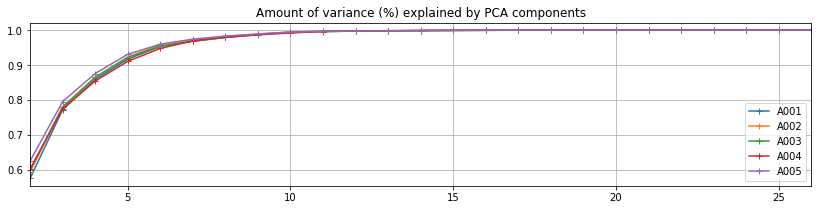

In [3]:
from sklearn.decomposition import PCA

col_to_not_use = ['asset', 'timestamp', 'fcast_time', 'fcast_day', 'day'] # const, used later

df_perf_pca = pd.DataFrame(index=range(2, len(df_raw.columns)-len(col_to_not_use)), columns=df_raw.asset.unique())
for a in df_raw.asset.unique():
    df_raw_a = df_raw.loc[df_raw.asset==a]
    for n in df_perf_pca.index:
        pca = PCA(n_components=n)
        df_pca = df_raw_a.loc[:, [x for x in df_raw_a.columns if x not in col_to_not_use]]
        pca.fit(df_pca.dropna().values)
        df_perf_pca.loc[n,a] = sum(pca.explained_variance_ratio_)

# plot
df_perf_pca.plot(marker='+', figsize=(14,3))
plt.grid()
plt.title('Amount of variance (%) explained by PCA components')
plt.show()

In [4]:
df_perf_pca.loc[range(8,14)]

,A001,A002,A003,A004,A005
8,0.978972,0.982194,0.979103,0.979223,0.982818
9,0.988211,0.98895,0.987526,0.986485,0.988914
10,0.994515,0.994457,0.99292,0.992029,0.994321
11,0.996953,0.996599,0.996096,0.995802,0.996269
12,0.997857,0.997699,0.997046,0.997346,0.99724
13,0.998436,0.998581,0.997944,0.998136,0.997915


With such analysis a value of <b> keeping 12 components on HK data allow us to keep 99.7% (3-sigma) of the information </b>

##  3) Learning

### Understanding of the goal
The goal is to predict the variable 'WTURPower' from each asset based on the housekeeping telemetry reported by each asset on the day (sampled every 10 minutes) and the weather forecast (provided by wind speed and temperature, sampled every 60 minutes).

### Understanding of the input data
The HK (housekeeping, sensor) data allows us to understand the status of a given asset. If for example, a turbine is faulty, it would be reported in the HK data and the prediction should consider this.

The weather data is highly correlated to the output power and its information contributes highly to the prediction of the power. Note that this data is reported every hour, while the prediction needs to be done for every 10 minutes.

### Approach
The data will be split for every asset. It is considered that no reliable entropy can be transferred from one asset to the other.

The idea is to follow a two step approach:
* To predict the output power every hour for the next seven days.
* To interpolate the predicted points (@60min) to derive a higher frequency (@10min).

Note that a good algorithm design would also parametrize the sampling frequencies in a way that either the input weather forecast data is interpolated or the output is interpolated. For memory management reasons, and because in any case we are incurring into self-interpolation, the latter is chosen.

The idea is to fit a function (e.g. linear coefficients, MLP weights...) that from the HK data of the previous day and the weather forecasts from today to the next seven days, can compute the output power.


$$ \hat{x_{pow}}(d, \tau) = h (X_{raw}(d-1),  \hat{x_{wind}}(d, \tau), \hat{x_{temp}}(d, \tau)) $$

### Optimization and prediction
The approach is based on the uber-helpful `GridSearchCV` component from `scikit-learn` that allow to split the input dataset into a train and cross-validation dataset and optimize the output performances: given an input pipeline the object would determine which combination of the input parameter space provides the optimum results.

The pipeline performs the following steps:
* Reduce the dimensions to 12+2 components.
* Introduce polynomial features (degree 2).
* Scale the input features, to bring all of them to the (-1, 1) range. Note that most of the input features already are.
* Perform a prediction based on one of the input regressors and configuration parameters.

Several prediction methods are used, among others: Ridge (standard linear regression with regularization), SVR (Support Vector Regression), Bayesian regression, Fully-connected neural networks.

### Cross-validation and testing
The learned coefficients need to be cross-validated and tested.

The cross-validation (i.e. ensuring that the configuration parameters of the regression algorithm are the optimum) is taken care of by the `GridSearchCV` function. It will test all the possible permutations of the configuration parameters (given by the dictionary `params`).

The learned parameter are then tested against a true referenced (not used in the training set). To have a clear snapshot of the requested prediction it was chosen not to isolate random records of the input feature matrix, but to isolate full days. 

This way the current algorithm first splits the dataset into a train set and a test set. The test set contains <b> 5 random days </b>, which are not used for the learning exercise, but only to test the performance.


In [5]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# prediction configuration
col_to_pred = ['true_WTURPower']
col_to_not_use = ['asset', 'timestamp', 'fcast_time', 'fcast_day', 'day']
col_out =['asset', 'range', 'fcast_day', 'pred_WTURPower','true_WTURPower']   
col_to_not_use.extend(col_to_pred)
col_to_not_use.extend(['pred_WTURPower']) # for recurrent tests
   
# data preparation for a single asset
def train_test_split_day(df_raw, df_fcast, assets=['A001'], num_days=1):
    ''' Prepares the input datasets and creates a train and test dataset
    '''
    test_days = np.random.choice(df_fcast.fcast_day.unique(), size=(num_days,))
    print ("Selected day for testing = {}".format(test_days))
    
    # filter for assets
    train_list = []
    test_list = []
    for a in assets:
        print('Preparing dataset for {}'.format(a))
        df_raw_a = df_raw.loc[df_raw.asset==a].copy()
        df_raw_a.loc[:, 'fcast_day'] = df_raw_a.day + pd.Timedelta(1, 'd')
        # merge on forecast and raw HK
        df = df_raw_a.merge(df_fcast, on=['fcast_day', 'asset'])
        # provide the true power
        df.set_index(['fcast_time'], inplace=True)
        df_raw_a.set_index(['timestamp'], inplace=True)
        df.loc[:, 'true_WTURPower'] = df_raw_a.loc[df.index, 'WTURPower']
        df.reset_index(inplace=True)

        # keep the test_days
        test_ind=[]
        for d in test_days:
            test_ind.extend(df.loc[df.fcast_day==d].index)    
        test_list.append(df.loc[test_ind])
        train_list.append(df.loc[set(df.index)-set(test_ind)])
    return pd.concat(train_list), pd.concat(test_list)

def optimize_and_predict(df, regressor, params):
    """ This function will run an optimized search accross a set of regressors
    and regression parameters to provide the best fit to the training set.
    The algorithm uses GridSearch and Pipelines, it scales the input training data
    and provides an output regressor to evaluate performance and perform predictions
    """
    
     
    # static values for prediction
    ss = StandardScaler()
    pca = PCA(n_components=14)
    poly = PolynomialFeatures(2)
    pred_pipe = Pipeline([('pca', pca), ('poly', poly), ('scaling', ss), ('prediction', regressor)])
    params_to_tweak = {'prediction__'+k:v for (k,v) in zip(params.keys(), params.values())}
    gs_pred = GridSearchCV(pred_pipe, params_to_tweak, n_jobs=1)
 
    # generate the train dataset, GridSearch will automatically split in train and cross-val
    df_x = df[[x for x in df.columns if x not in col_to_not_use]]
    df_y = df[col_to_pred]
    
    # predict
    gs_pred = gs_pred.fit(df_x.values, df_y.values)
    df.loc[:, 'pred_WTURPower'] = gs_pred.predict(df_x)    
    
    print ("Best parameters: {}".format(gs_pred.best_params_))
    
    return df[col_out], gs_pred

def predict_with_pipeline (pipe, df_in):
    '''Predict given an input pipe
    '''
    df_x = df_in[[x for x in df_in.columns if x not in col_to_not_use]]
    df_in.loc[:, 'pred_WTURPower'] = pipe.predict(df_x.dropna())
    return df_in[col_out]



In [6]:
train_assets = ['A001']
df_train, df_test = train_test_split_day(df_raw, df_fcast, assets=train_assets, num_days=5)

Selected day for testing = ['2015-04-11T00:00:00.000000000' '2015-07-13T00:00:00.000000000'
 '2015-07-10T00:00:00.000000000' '2015-08-08T00:00:00.000000000'
 '2015-04-19T00:00:00.000000000']
Preparing dataset for A001


### 3.1) Ridge regression (linear with regularization)

Best parameters: {'prediction__alpha': 100.0}


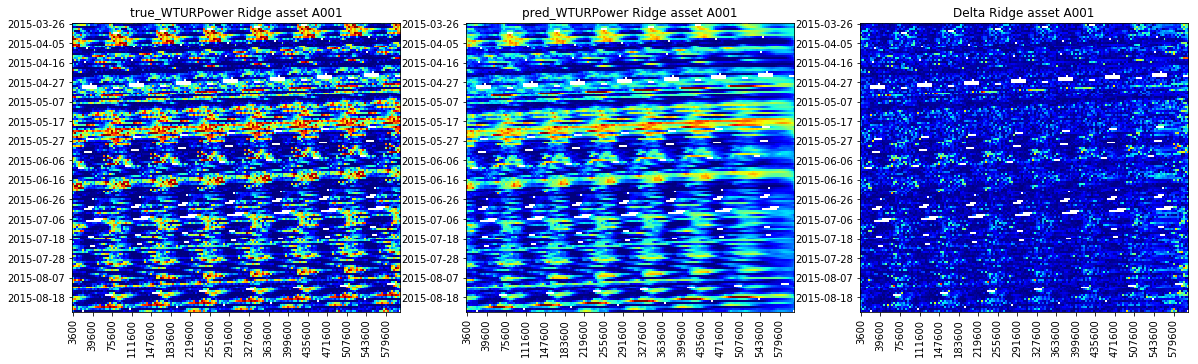

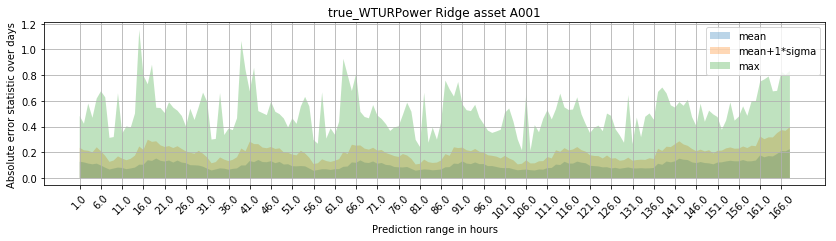

MSE error = 0.021521720559946098
R2 score = 0.6721112066365096
Performance on a test dataset of 5 days


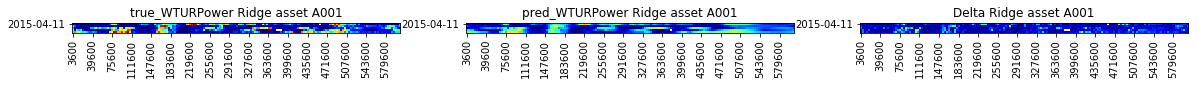

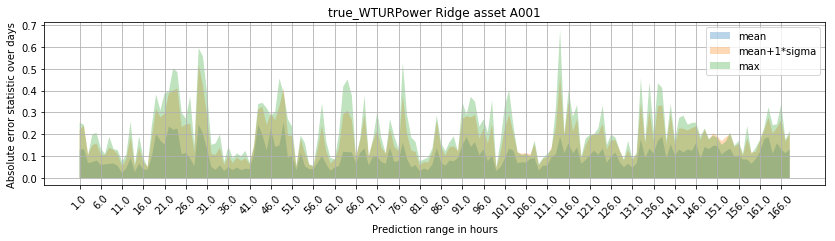

MSE error = 0.02065237182930599
R2 score = 0.6394479139207088


In [7]:
from sklearn.linear_model import Ridge

# train and plot performance on train dataset
df_out, gs_pred = optimize_and_predict(df_train.dropna(), Ridge(), {'alpha':[1e-2, 1, 1e2]} )
asset_performance_report(df_out, train_assets, 'true_WTURPower', 'pred_WTURPower', comment='Ridge')

print ("Performance on a test dataset of {} days".format(len(df_test.fcast_day.unique())))
df_test_out = predict_with_pipeline(gs_pred, df_test)
asset_performance_report(df_test_out, train_assets, 'true_WTURPower', 'pred_WTURPower', comment='Ridge')

### 3.2) Full-connected neural network (MLP)
Note activation unit is 'identity' since this is regression, not classfication.

Best parameters: {'prediction__activation': 'identity', 'prediction__alpha': 0.001, 'prediction__hidden_layer_sizes': (25, 10)}


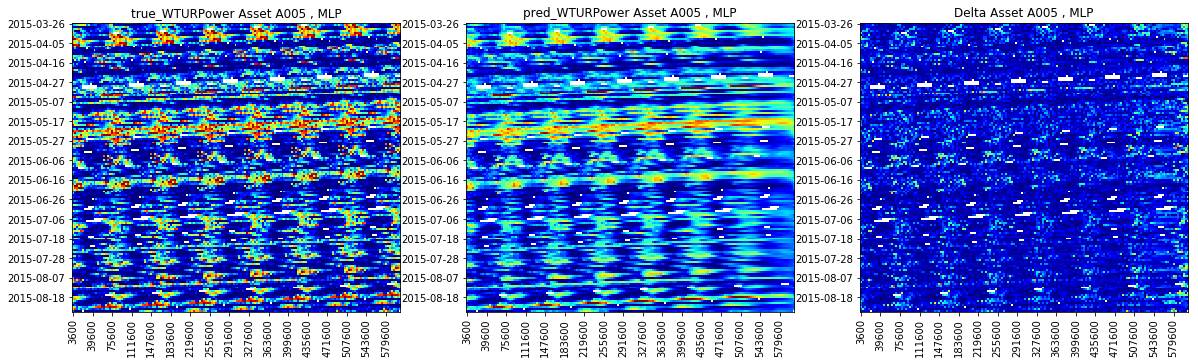

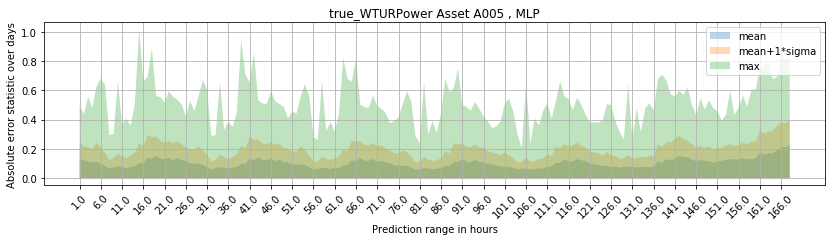

MSE error = 0.021689411839162346
R2 score = 0.6695563880732518
Performance on a test dataset of 5 days


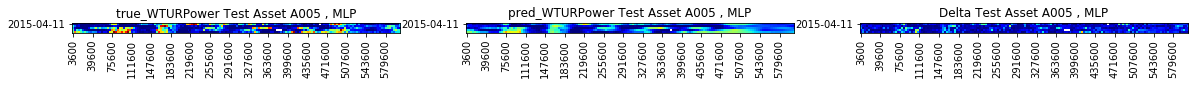

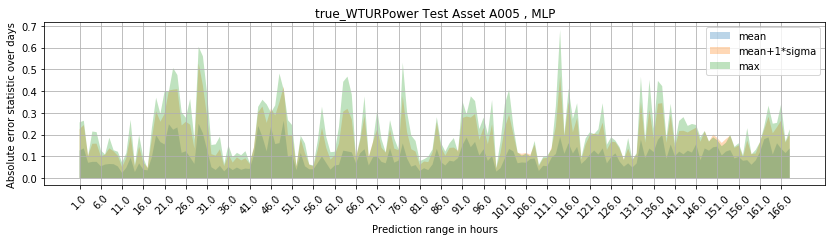

MSE error = 0.020974849745353734
R2 score = 0.6338180479514872


In [8]:
from sklearn.neural_network import MLPRegressor

# train and plot performance on train dataset
params = {'hidden_layer_sizes':[(10,), (25, 10)], 'activation':['identity'], 'alpha':[1, 1e-3]}
df_out, gs_pred = optimize_and_predict(df_train.dropna(), MLPRegressor(), params )
plot_prediction_report(df_out, 'true_WTURPower', 'pred_WTURPower', comment='Asset '+a+' , MLP')

print ("Performance on a test dataset of {} days".format(len(df_test.fcast_day.unique())))
df_test_out = predict_with_pipeline(gs_pred, df_test)
plot_prediction_report(df_test_out, 'true_WTURPower', 'pred_WTURPower', comment='Test Asset '+a+' , MLP')  

## 4) Prediction

This section reads the files to be evaluated and performs a prediction over 10 minutes.

Selected day for testing = []
Preparing dataset for A001
Best parameters: {'prediction__activation': 'identity', 'prediction__alpha': 0.001, 'prediction__hidden_layer_sizes': (25, 10)}
Selected day for testing = []
Preparing dataset for A001
Selected day for testing = []
Preparing dataset for A002
Best parameters: {'prediction__activation': 'identity', 'prediction__alpha': 0.001, 'prediction__hidden_layer_sizes': (25, 10)}
Selected day for testing = []
Preparing dataset for A002
Selected day for testing = []
Preparing dataset for A003
Best parameters: {'prediction__activation': 'identity', 'prediction__alpha': 0.001, 'prediction__hidden_layer_sizes': (25, 10)}
Selected day for testing = []
Preparing dataset for A003
Selected day for testing = []
Preparing dataset for A004
Best parameters: {'prediction__activation': 'identity', 'prediction__alpha': 0.001, 'prediction__hidden_layer_sizes': (25, 10)}
Selected day for testing = []
Preparing dataset for A004
Selected day for testing = []
Pr

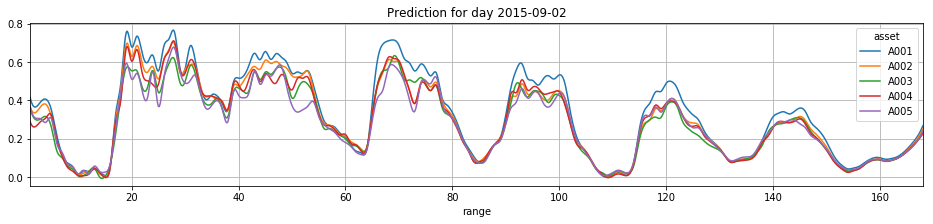

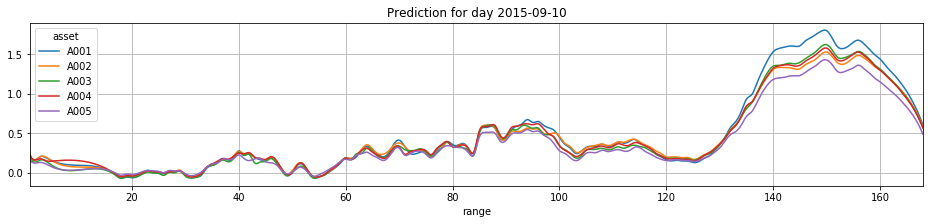

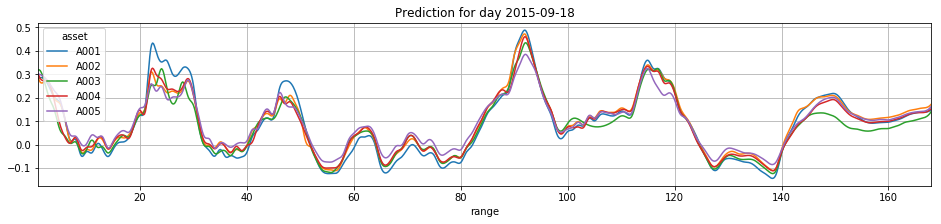

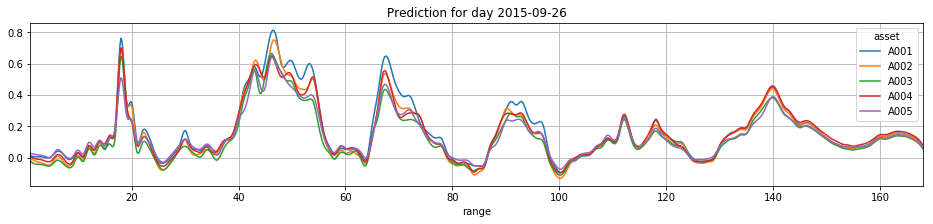

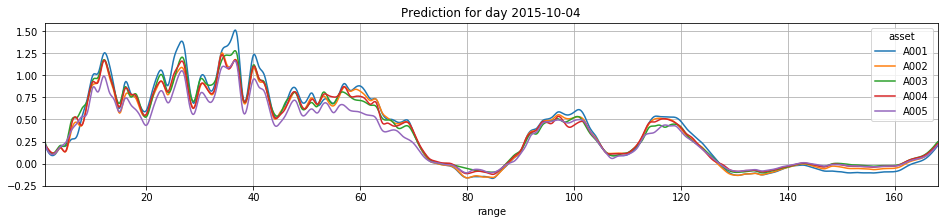

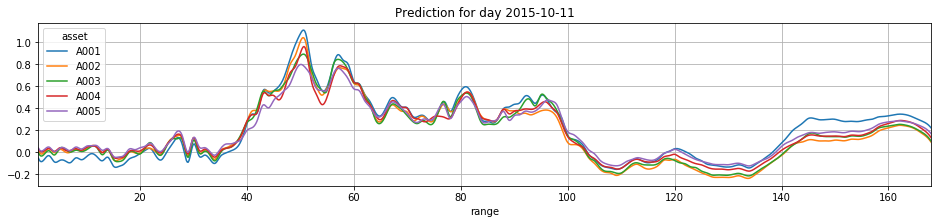

Files successfully written in disk!


In [9]:
from scipy.interpolate import interp1d

raw_files_dir = os.path.join('..', 'data', 'evaluation', 'online')
forecast_files_dir = os.path.join('..', 'data', 'evaluation', 'forecasts')
df_raw_eval, df_fcast_eval = read_files(raw_files_dir, forecast_files_dir)

pred_list = []
regressor_dict = {}
# optimized parameters coming from analysis above
params = {'hidden_layer_sizes':[(25, 10)], 'activation':['identity'], 'alpha':[1e-3]}
for a in df_raw.asset.unique():
    # create a pipeline with the settings optimized over the full training set
    df_train, df_test = train_test_split_day(df_raw, df_fcast, assets=[a], num_days=0)
    df_out, gs_pred = optimize_and_predict(df_train.dropna(), MLPRegressor(), params )
    # predict and append
    df_eval, foo = train_test_split_day(df_raw_eval, df_fcast_eval, assets=[a], num_days=0)
    pred_list.append(predict_with_pipeline(gs_pred, df_eval))
    regressor_dict[a] = gs_pred # for post-analysis
df_eval_out = pd.concat(pred_list)
df_eval_out.loc[:, 'fcast_day'] = df_eval_out.fcast_day.apply(lambda x: x.date())
df_eval_out.dropna(axis=1, inplace=True)  # clear up the true value, not available

def interpolate_to_hf(df):
    df_list = []
    for a in df.asset.unique():
        df_a = df.loc[df.asset==a]
        x_in = df_a.dropna().range
        y_in = df_a.dropna().pred_WTURPower
        x_out = df_a.range
        f = interp1d(x_in, y_in, kind='cubic')
        df_a.loc[:, 'pred_WTURPower'] = f(x_out)
        df_list.append(df_a)
    return pd.concat(df_list)

def plot_eval(df_in, d):
    df = pd.pivot_table(df_in, columns='asset', index='range', values='pred_WTURPower')
    df.index = df.index/3600 # show hours
    df.plot(figsize=(16,3))
    plt.title('Prediction for day {}'.format(d))
    plt.grid()
    plt.show()

new_range = list(range(df_eval_out.range.min(), df_eval_out.range.max()+600, 600))
multiind = pd.MultiIndex.from_product([list(df_eval_out.asset.unique()), new_range], names=['asset', 'range'])
for d in df_eval_out.fcast_day.unique():
    df_priori = df_eval_out.loc[df_eval_out.fcast_day==d].set_index(['asset', 'range'])
    df_post = pd.DataFrame(columns =df_priori.columns, index=multiind)
    df_post.loc[df_priori.index, 'pred_WTURPower'] = df_priori.pred_WTURPower
    df_post.loc[:, 'fcast_day'] = d
    df_post.reset_index(inplace=True)
    # interpolation
    df_post = interpolate_to_hf(df_post)
    plot_eval(df_post, d)
    # save to disk
    df_post[['asset', 'range', 'pred_WTURPower']].to_csv(str(d)+'.csv', header=True, index=False)
    
print('Files successfully written in disk!')

# 5) Conclusion

* An approach to predict wind turbine output power using sensor HK data from wind-turbines and weather forecasts has been designed and proven.
* The approach is flexible: it can use any regression algorithm from `scikit-learn` and will optimize the performance using `GridSearchCV`.
* Several preprocessing steps are piped including: polynomial features, PCA and scaling of the input features.
* Some days for test (not used for training or cross-val) has been set aside to test the goodness of the prediction, providing similar results to the training set error.
* From the tested algorithms, the algorithm with better performance is a Neural Network with two hidden layers and regularization. It does not improve dramatically, however, the performance of a standard linear regression with regularization.

### Limitations and future work

The lack of available personal time to work on this challenge penalized the final score achieved by the prediction. The following are points that, with more time would be investigated and researched.

* The current approach does not mix data from one asset to the other. I personally do not have insight on how much reliable is the entropy of one asset to the other, but the algorithm should allow to use the maximum volume of data. The current code allows to mix all the data from the assets (`train_test_split_day` parameter `assets`) but it results in a memory overflow due to permutations, with my current hardware setup (laptop).
* Given the pre-processing step of moving average (10 min) and the point above about the number of assets, one could think of using other technologies such as <b>Apache Spark MLib </b> to the machine learning.
* `scikit-learn` neural-networks aren't optimized. On the other hand, <b>TensorFlow</b> uses graphs to compute symbolic gradients instead of numerical gradients. This results in a better and faster estimation. Personal work done with TF can be found on <a>https://github.com/drublackberry/prove-it/blob/master/TensorFlow/TensorFlowAdvanced.ipynb</a>.
* More time would have resulted in a better research on which algorithms or parameters provide the best estimation.
* The interpolation to retrieve data at 10 minutes sampling is done a posteriori - over the estimated output power. It should be analysed whether it is better to interpolate the input data (weather forecasts) and learn over the interpolated parameters. The penalty for this technique is an increase in data, and hence, the learning process is more computing hungry.
* The interpolation used is a spline. Given the amount of points >> 3, experience shows that it provides better results than linear or other interpolation techniques. However, it should be validated and evaluated if another interpolation technique improves the accuracy of the prediction.
* Given the amount of time only a limited subset of parameters has been tried out, a better combination might be possible. However, for MLP the output activation is disabled (i.e. identity) sincet this is a regression task, not classification.


